In [ ]:
!pip install -q transformers sentencepiece sentence-transformers catboost wordcloud pymorphy2 deep-translator

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from catboost import Pool
import re, string
import nltk
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from pymorphy2 import MorphAnalyzer
from sklearn.linear_model import LogisticRegression


nltk.download("stopwords")
russian_stopwords = stopwords.words("russian")
morph = MorphAnalyzer()

sns.set(rc={'figure.figsize':(30,25)})
%matplotlib inline

In [79]:
def preprocess(text):

    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile(f'[{re.escape(string.punctuation)}]').sub(' ', text)
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    # text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    # text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 

    return text

def stopword(string):
    a = [i for i in string.split() if i not in stopwords.words('russian')]
    return ' '.join(a)

def make_features(df):
    df["len name"] = df["name"].str.len() # надо смотреть до и после предобработки

    categories = ["хлеб", "пиво", "вода", "сигареты", "молоко", "3.2", "макароны",
                  "фрукт", 'молоч', 'газ', 'кола', '1л', '0.5л', '%', 'пастер', 'бзмж']

    for category in categories:
        df[category] = df["name"].map(lambda x: category in x.lower())

    df['len_eng'] = df["name"].apply(lambda x: len([i for i in x if i in 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz']))
    df['len_num'] = df["name"].apply(lambda x: len([i for i in x if i in '1234567890']))
    df['len_punct'] = df["name"].apply(lambda x: len([i for i in x if i in string.punctuation]))
    df['len_word'] = df["name"].apply(lambda x: len(x.split()))

    df['name'] = df['name'].apply(lambda x: x.lower().replace('big', 'биг').replace('bon', 'бон'))

    return df

def lemmatize(string):
    # word_list = [morph.parse(word)[0].normal_form for word in string.split()]
    # return ' '.join([morph.parse(word)[0].normal_form for word in string.split()])
    return GoogleTranslator(source='english', target='russian').translate(string)

In [80]:
# df = pd.read_csv("/content/drive/MyDrive/Olimpiads/saratov_cp/Саратов/train_dataset_train (3).csv")
df = pd.read_csv('/Users/nikitaromanov/Downloads/Саратов/train_dataset_train (1).csv')
sample_solution = pd.read_csv('/Users/nikitaromanov/Downloads/Саратов/sample_solution.csv')
test = pd.read_csv('/Users/nikitaromanov/Downloads/Саратов/test_dataset_test (1).csv')
test = test.dropna()

df = make_features(df)
df['name'] = df['name'].apply(preprocess)
df['name'] = df['name'].apply(stopword)
df['name'] = df['name'].apply(lemmatize)

test = make_features(test)
test['name'] = test['name'].apply(preprocess)
test['name'] = test['name'].apply(stopword)
test['name'] = test['name'].apply(lemmatize)

## Рассмотрим датасет поближе

In [48]:
df.head(30)

,id,name,groups,len name,хлеб,пиво,вода,сигареты,молоко,3.2,...,фрукт,молоч,газ,кола,1л,0.5л,%,пастер,len_eng,len_num
0,2442477,бзмжа молоко ультропаста вкуснотеево гр пэт б,3,49,False,False,False,False,True,True,...,False,False,False,False,False,False,True,False,0,5
1,1564599,ноутбук acer nitro an ll fhd ips i h ssd nv gt...,10,100,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,39,30
2,841848,жев резинка орбита нежный мятый xx,10,41,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,2,8
3,960348,агрикола грунт универсальный л техноэкспорт,10,50,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,0,3
4,398622,игристый вино каспийский коллекция зга дагеста...,10,96,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,0,11
5,2743476,напиток алый вера б г л вт,4,30,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,2
6,3832875,воздушный рис дансония карамель г,10,41,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,4
7,4906316,салат сельдь шуба,10,29,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,0
8,2420905,молоко пастерил резной палисад г бзмжа,3,48,False,False,False,False,True,False,...,False,False,False,False,False,False,True,True,0,6
9,405595,вино пиросманить красный полусладкое л,10,46,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,0,6


### Пострим на распределение данных

<AxesSubplot:xlabel='len name', ylabel='count'>

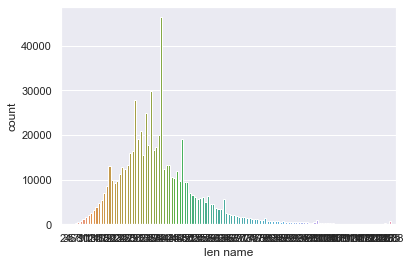

In [ ]:
sns.countplot(x = "len name" , data  = df)  

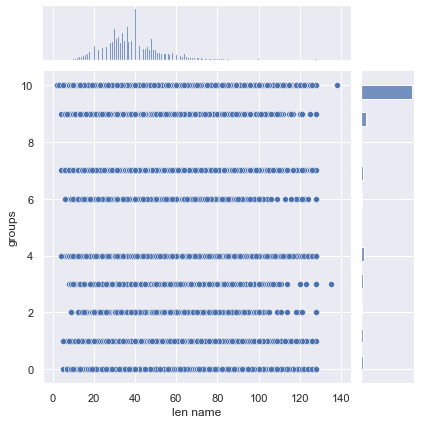

In [ ]:
sns.jointplot(x = 'len name', y = "groups" , data = df)

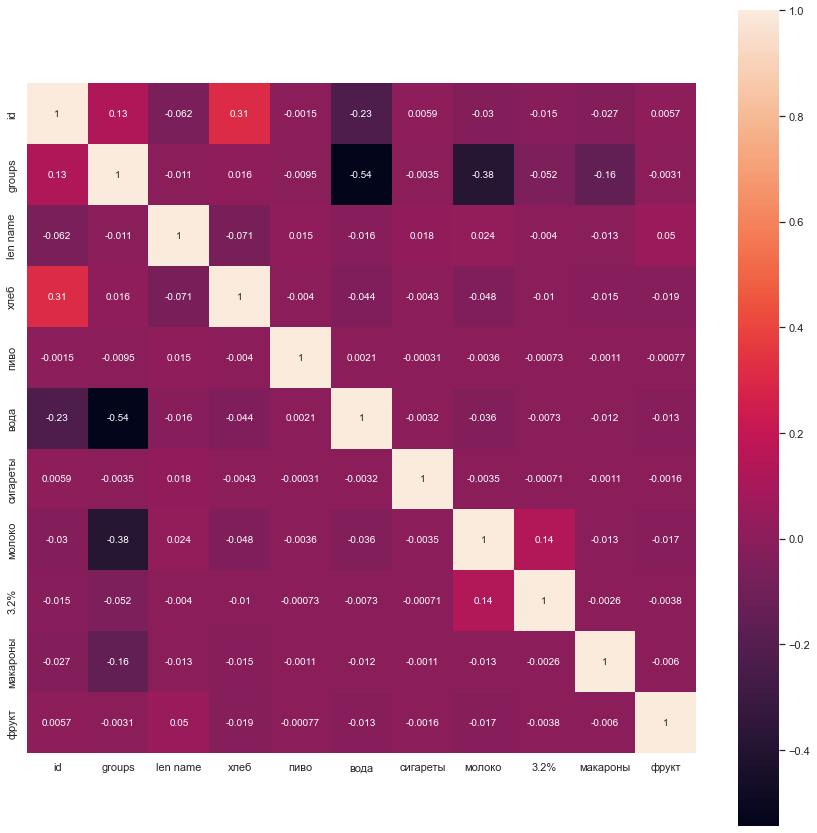

In [ ]:
plt.rcParams['figure.figsize']=(15,15)

corr = df.corr()
g = sns.heatmap(corr, square = True, annot=True)

## Пробуем nlp

<AxesSubplot:>

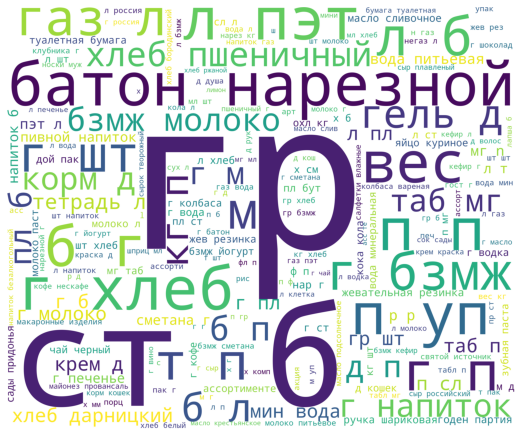

In [9]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''.join(f' {i}' for i in corpus)
    str_corpus = str_corpus.strip()
    return str_corpus
# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        corpus.extend(iter(phrase.split()))
    return corpus
# Получение облака слов
def get_wordCloud(corpus):
    return WordCloud(background_color='white', width=3000, height=2500, max_words=200, random_state=42).generate(str_corpus(corpus))

corpus = get_corpus(df['name'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

### Первый подход - Catboost

In [81]:
vectorizer1 = CountVectorizer()
# X = hstack((vectorizer1.fit_transform(df['name']), vectorizer2.fit_transform(df['name'])))
X = vectorizer1.fit_transform(df['name'])
y = df.groups
X = hstack((scipy.sparse.csr_matrix(df.drop(['name', 'groups', 'id'], axis=1).astype(float).values), X))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
# переобучения нет, можно обучать без теста под конец

clf = CatBoostClassifier(random_state=42, iterations=1200, early_stopping_rounds=80,
                         use_best_model=True, learning_rate=0.140258)

pool_train = Pool(X_train, y_train)
pool_test = Pool(X_test, y_test)

clf.fit(pool_train, verbose=100, eval_set=pool_test, plot=True)

In [ ]:
# без теста
clf = CatBoostClassifier(random_state=42, iterations=1100,learning_rate=0.140258)
pool_train = Pool(X, y)
clf.fit(pool_train, verbose=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.3574207	total: 757ms	remaining: 13m 52s
100:	learn: 0.1255729	total: 1m 8s	remaining: 11m 16s
200:	learn: 0.0995850	total: 2m 15s	remaining: 10m 4s
300:	learn: 0.0893682	total: 3m 21s	remaining: 8m 54s
400:	learn: 0.0818254	total: 4m 26s	remaining: 7m 45s
500:	learn: 0.0769809	total: 5m 32s	remaining: 6m 37s
600:	learn: 0.0735739	total: 6m 37s	remaining: 5m 29s
700:	learn: 0.0711457	total: 7m 42s	remaining: 4m 23s
800:	learn: 0.0688217	total: 8m 47s	remaining: 3m 16s
900:	learn: 0.0675466	total: 9m 52s	remaining: 2m 10s
1000:	learn: 0.0662033	total: 10m 59s	remaining: 1m 5s
1099:	learn: 0.0648731	total: 12m 13s	remaining: 0us


In [52]:
from sklearn.metrics import classification_report
print(classification_report(clf.predict(X), y)) # 0.938458

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     21590
           1       0.71      0.96      0.81     12697
           2       0.93      0.97      0.95      3755
           3       0.99      0.97      0.98     21450
           4       0.99      0.98      0.99     27954
           6       0.91      0.94      0.92      9648
           7       0.94      0.90      0.92     12557
           9       0.99      0.94      0.96     44457
          10       0.99      0.99      0.99    503956

    accuracy                           0.98    658064
   macro avg       0.94      0.96      0.95    658064
weighted avg       0.98      0.98      0.98    658064



### Второй подход - logistic regression 

In [82]:
clf = LogisticRegression(random_state=42, max_iter=20000, solver='lbfgs')
clf.fit(X, y)

LogisticRegression(max_iter=20000, random_state=42)

In [83]:
print(classification_report(clf.predict(X), y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21564
           1       0.86      0.96      0.91     15372
           2       0.96      0.99      0.97      3784
           3       1.00      0.99      0.99     21244
           4       1.00      0.99      0.99     27690
           6       0.97      0.98      0.98      9952
           7       0.96      0.97      0.97     11916
           9       0.99      0.98      0.98     42659
          10       1.00      1.00      1.00    503883

    accuracy                           0.99    658064
   macro avg       0.97      0.98      0.98    658064
weighted avg       0.99      0.99      0.99    658064



## Bert

In [4]:
import pandas as pd
from transformers import AutoModel, AutoTokenizer, Trainer, TrainingArguments, default_data_collator, DebertaV2Tokenizer, PegasusForConditionalGeneration, PegasusTokenizer
from tqdm.notebook import tqdm
import torch 
from sentence_transformers import SentenceTransformer
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor
import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import numpy as np
import requests
from bs4 import BeautifulSoup

In [ ]:
def create_folds(data, target, num_splits=3):
    if num_splits > 1:
        data.loc[:,'kfold'] = -1
        X = data.drop([target], axis=1)
        y = data[[target]]
        mskf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
        for fold, (trn_, val_) in enumerate(mskf.split(data)):
            data.loc[val_,'kfold'] = fold
    else:
        data.loc[:,'kfold'] = 0
    return data

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0].detach().cpu() #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def make_features_transformers(df, model_name, df_model, col, max_len):
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModel.from_pretrained(model_name).cuda()
  text_features = []
  for sentence in tqdm(df[col]):
    encoded_input = tokenizer([sentence], padding='max_length', truncation=True, max_length=max_len, return_tensors='pt')
    with torch.no_grad():
      model_output = model(input_ids=encoded_input['input_ids'].cuda())
    sentence_embeddings = list(mean_pooling(model_output, encoded_input['attention_mask']).numpy())
    text_features.extend(sentence_embeddings)
  text_features_df = pd.DataFrame(text_features, columns = [f'{df_model}_{col}_feature_{i}' for i in range(len(text_features[0]))])
  return text_features_df

def make_labse(df, col):
  df_model = 'labse'
  model = SentenceTransformer('sentence-transformers/LaBSE')
  text_features = []
  for sentence in tqdm(df[col]):
    sentence_embeddings = list(model.encode([sentence]))
    text_features.extend(sentence_embeddings)
  text_features_df = pd.DataFrame(text_features, columns = [f'{df_model}_{col}_feature_{i}' for i in range(len(text_features[0]))])
  return text_features_df

In [ ]:
df.name = df.name.astype(str)
train = df.copy()

In [ ]:
models = [('sberbank-ai/ruRoberta-large', 512), ('sberbank-ai/sbert_large_nlu_ru', 512), ('sberbank-ai/sbert_large_mt_nlu_ru', 512), ('sberbank-ai/ruBert-large', 512), ('sberbank-ai/ruBert-base', 512), ('cointegrated/rubert-tiny2', 2048), ('DeepPavlov/rubert-base-cased-conversational', 512), ('cointegrated/LaBSE-en-ru', 512), ('microsoft/mdeberta-v3-base', 512), ('vicgalle/xlm-roberta-large-xnli-anli', 512), ('MoritzLaurer/mDeBERTa-v3-base-mnli-xnli', 512), ('facebook/bart-large-mnli', 1024)]
for m in models:
  print(m)
  train = train.join(make_features_transformers(train, m[0], m[0].split('/')[1], 'name', m[1]))
  train.to_csv('rosstat_transformers_text_features.csv', index=False)

In [ ]:
models = [('cointegrated/rubert-tiny2', 2048)]
for m in models:
  print(m)
  train = train.join(make_features_transformers(train, m[0], m[0].split('/')[1], 'name', m[1]))
  train.to_csv('drive/MyDrive/rosstat_transformers_text_features.csv', index=False)

In [ ]:
train.head()

,id,name,groups,rubert-tiny2_name_feature_0,rubert-tiny2_name_feature_1,rubert-tiny2_name_feature_2,rubert-tiny2_name_feature_3,rubert-tiny2_name_feature_4,rubert-tiny2_name_feature_5,rubert-tiny2_name_feature_6,...,rubert-tiny2_name_feature_302,rubert-tiny2_name_feature_303,rubert-tiny2_name_feature_304,rubert-tiny2_name_feature_305,rubert-tiny2_name_feature_306,rubert-tiny2_name_feature_307,rubert-tiny2_name_feature_308,rubert-tiny2_name_feature_309,rubert-tiny2_name_feature_310,rubert-tiny2_name_feature_311
0,2442477,БЗМЖ Молоко ультропаст.Вкуснотеево900гр.3.2%ПЭТ/б,3,-0.166159,0.087524,0.271790,-1.242290,-0.710111,0.044824,-1.005936,...,-0.093222,-0.708089,0.252329,-0.370362,-0.250257,-1.156491,0.074167,-0.577111,0.790022,-1.903245
1,1564599,"15.6"" Ноутбук Acer Nitro 5 (AN515-54-58LL)(FHD...",10,-0.526832,0.225761,0.419643,-1.629439,-0.936959,0.057511,-1.013047,...,-0.247578,-1.097395,-0.039849,-0.469456,-0.711339,-1.171292,-0.101088,-0.710577,0.337047,-1.540218
2,841848,ЖЕВ.РЕЗИНКА ОРБИТ НЕЖНАЯ МЯТА XX 46153708,10,-0.078312,0.320307,0.034245,-0.982133,-0.518016,-0.326884,-1.153606,...,-0.033994,-0.852282,0.482827,-0.299770,-0.547080,-1.029889,0.032011,-0.706050,0.229052,-2.322481
3,960348,Агрикола Грунт универсальный 50 л (Техноэкспор...,10,-0.078146,0.028776,-0.467028,-1.401549,-0.570675,0.100153,-0.713694,...,0.121347,-0.492925,0.324872,-0.330109,-0.460007,-0.973028,0.038178,-0.515543,0.442988,-1.331011
4,398622,"1. Игристое вино ""Каспийская коллекция"" ЗГУ ""Д...",10,-0.311661,0.371281,0.073067,-1.359792,-0.655184,0.098606,-0.874897,...,-0.091377,-0.637281,-0.005537,-0.734867,-0.549709,-1.439004,0.140062,-0.744900,0.601676,-1.633550


In [ ]:
def make_labse(df, col):
  df_model = 'labse'
  model = SentenceTransformer('sentence-transformers/LaBSE')
  text_features = []
  for sentence in tqdm(df[col]):
    sentence_embeddings = list(model.encode([sentence]))
    text_features.extend(sentence_embeddings)
  text_features_df = pd.DataFrame(text_features, columns = [f'{df_model}_{col}_feature_{i}' for i in range(len(text_features[0]))])
  return text_features_df

train = train.join(make_labse(train, 'name'))
train.to_csv('drive/MyDrive/rosstat_transformers_features.csv', index=False)

In [5]:
train = pd.read_csv('drive/MyDrive/rosstat_transformers_text_features.csv')

In [6]:
X = train.drop(['id', 'name', 'groups'], axis=1)
y = train['groups']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

In [7]:
clf = CatBoostClassifier(random_state=42, iterations=800, early_stopping_rounds=60,
                         use_best_model=True)

In [8]:
pool_train = Pool(X_train, y_train)
pool_test = Pool(X_test, y_test)

clf.fit(pool_train, verbose=100, eval_set=pool_test)

Learning rate set to 0.133283
0:	learn: 1.6287545	test: 1.6286156	best: 1.6286156 (0)	total: 7.34s	remaining: 1h 37m 43s
100:	learn: 0.4421168	test: 0.4484675	best: 0.4484675 (100)	total: 15m 19s	remaining: 1h 46m 5s
200:	learn: 0.3424588	test: 0.3550712	best: 0.3550712 (200)	total: 26m 56s	remaining: 1h 20m 18s
300:	learn: 0.2915978	test: 0.3097058	best: 0.3097058 (300)	total: 38m 14s	remaining: 1h 3m 23s
400:	learn: 0.2585880	test: 0.2815387	best: 0.2815387 (400)	total: 49m 1s	remaining: 48m 47s
500:	learn: 0.2360819	test: 0.2628787	best: 0.2628787 (500)	total: 59m 17s	remaining: 35m 22s
600:	learn: 0.2187520	test: 0.2490742	best: 0.2490742 (600)	total: 1h 9m 11s	remaining: 22m 54s
700:	learn: 0.2053108	test: 0.2387881	best: 0.2387881 (700)	total: 1h 18m 34s	remaining: 11m 5s
799:	learn: 0.1940973	test: 0.2301824	best: 0.2301824 (799)	total: 1h 27m 44s	remaining: 0us

bestTest = 0.2301824424
bestIteration = 799



In [9]:
clf.save_model('drive/MyDrive/bert_cat.cbm')

## Делаем submit

### Делаем сабмит с Бертом

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Olimpiads/saratov_cp/Саратов/test_dataset_test (3).csv')
test = test[:282227]
test['name'] = test['name'].astype(str)

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0].detach().cpu() #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def make_features_transformers(df, model_name, df_model, col, max_len):
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModel.from_pretrained(model_name).cuda()
  text_features = []
  for sentence in tqdm(df[col]):
    encoded_input = tokenizer([sentence], padding='max_length', truncation=True, max_length=max_len, return_tensors='pt')
    with torch.no_grad():
      model_output = model(input_ids=encoded_input['input_ids'].cuda())
    sentence_embeddings = list(mean_pooling(model_output, encoded_input['attention_mask']).numpy())
    text_features.extend(sentence_embeddings)
  text_features_df = pd.DataFrame(text_features, columns = [f'{df_model}_{col}_feature_{i}' for i in range(len(text_features[0]))])
  return text_features_df

In [ ]:
models = [('cointegrated/rubert-tiny2', 2048)]
for m in models:
  print(m)
  test = test.join(make_features_transformers(test, m[0], m[0].split('/')[1], 'name', m[1]))
  test.to_csv('drive/MyDrive/test_rosstat_transformers_text_features.csv', index=False)

In [ ]:
def make_labse(df, col):
  df_model = 'labse'
  model = SentenceTransformer('sentence-transformers/LaBSE')
  text_features = []
  for sentence in tqdm(df[col]):
    sentence_embeddings = list(model.encode([sentence]))
    text_features.extend(sentence_embeddings)
  text_features_df = pd.DataFrame(text_features, columns = [f'{df_model}_{col}_feature_{i}' for i in range(len(text_features[0]))])
  return text_features_df

In [ ]:
test = test.join(make_labse(test, 'name'))
test.to_csv('drive/MyDrive/test_rosstat_transformers_features.csv', index=False)

In [13]:
test = pd.read_csv('drive/MyDrive/test_rosstat_transformers_text_features.csv').drop(['id', 'name'], axis=1)
sample_solution = pd.read_csv('/content/drive/MyDrive/Olimpiads/saratov_cp/Саратов/sample_solution.csv')

In [14]:
sample_solution['groups'] = clf.predict(test)
sample_solution['groups'] = sample_solution['groups'].astype(float)

In [15]:
sample_solution.to_csv('/content/drive/MyDrive/Olimpiads/saratov_cp/Саратов/bert_solution.csv', index=False)

In [17]:
sample_solution.groups.value_counts()

10.0    229190
9.0      16169
4.0      10405
3.0       8465
0.0       8169
1.0       4918
6.0       2407
7.0       1560
2.0        944
Name: groups, dtype: int64

### Обычные Вектора

In [85]:
to_predict =  hstack((scipy.sparse.csr_matrix(test.drop(['name', 'id'], axis=1).astype(float).values), vectorizer1.transform(test['name'])))
sample_solution['groups'] = clf.predict(to_predict)
sample_solution['groups'] = sample_solution['groups'].astype(float)
sample_solution.id = test.id
sample_solution.to_csv('vectorised_solution.csv', index=False)
sample_solution['groups'].value_counts()

10.0    216330
9.0      18093
4.0      11807
0.0       9302
3.0       9014
1.0       6649
7.0       5140
6.0       4287
2.0       1605
Name: groups, dtype: int64